In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

import pyarrow.parquet as pq

sys.path.append("..")
from MLP_utils.utils import parameter_set
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)


sys.path.append("../..")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()

In [3]:
data = Path("../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

In [4]:
def test_loop(df, output_name, title):
    # Code snippet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df[df_metadata]
    df_values = df.drop(columns=df_metadata)
    # Creating label encoder
    le = preprocessing.LabelEncoder()
    # Converting strings into numbers
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    )
    # split into X and Y where Y are the predictive column and x are the observable data
    df_values_X = df_values.drop(
        [
            "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
            "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        ],
        axis=1,
    )
    df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    test_data = Dataset_formatter(
        torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
    )

    params.IN_FEATURES = df_values_X.shape[1]
    print("Number of in features: ", params.IN_FEATURES)
    if params.MODEL_TYPE == "Regression":
        params.OUT_FEATURES = 1
    else:
        params.OUT_FEATURES = len(
            df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )

    print("Number of out features: ", params.OUT_FEATURES)

    if params.OUT_FEATURES > 2:
        params.MODEL_TYPE = "Multi_Class"
    elif params.OUT_FEATURES == 2:
        params.OUT_FEATURES = params.OUT_FEATURES - 1
        params.MODEL_TYPE = "Binary_Classification"
    elif params.OUT_FEATURES == 1:
        params.MODEL_TYPE = "Regression"
    else:
        pass
    print(params.MODEL_TYPE)

    # convert data class into a dataloader to be compatible with pytorch
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)
    model = optimized_model_create(params, params.MODEL_NAME)
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        y_pred_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        y_pred_list, y_pred_prob_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

    # un-nest list if nested i.e. length of input data does not match length of output data
    if len(y_pred_list) != len(df_values_Y):
        y_pred_list = un_nest(y_pred_list)
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        pass
    # Call visualization function
    # calling the testing function and outputing list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        confusion_matrix_df = results_output(
            y_pred_list,
            df_values_Y,
            params,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        results_output(
            y_pred_list,
            df_values_Y,
            params,
            y_pred_prob_list,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
            title=title,
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

In [5]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['media ctr_0_Media ctr_0.0', 'DMSO_0.100_DMSO_1.0',
       'DMSO_0.100_Z-VAD-FMK_100.0', 'DMSO_0.100_Z-VAD-FMK_30.0',
       'DMSO_0.100_DMSO_0.025', 'Thapsigargin_1.000_DMSO_0.025',
       'Thapsigargin_10.000_DMSO_0.025', 'Topotecan_5.000_DMSO_0.025',
       'Topotecan_10.000_DMSO_0.025', 'Topotecan_20.000_DMSO_0.025',
       'LPS_0.010_DMSO_0.025', 'LPS_0.100_DMSO_0.025',
       'LPS_1.000_DMSO_0.025', 'LPS_10.000_DMSO_0.025',
       'LPS_10.000_Disulfiram_0.1', 'LPS_10.000_Disulfiram_1.0',
       'LPS_10.000_Disulfiram_2.5',
       'LPS_Nigericin_100.000_1.0_DMSO_0.025',
       'LPS_Nigericin_100.000_3.0_DMSO_0.025',
       'LPS_Nigericin_100.000_10.0_DMSO_0.025',
       'Disulfiram_0.100_DMSO_0.025', 'Disulfiram_1.000_DMSO_0.025',
       'Disulfiram_2.500_DMSO_0.025', 'H2O2_100.000_DMSO_0.025',
       'LPS_10.000_Z-VAD-FMK_100.0', 'LPS_100.000_DMSO_0.025',
       'LPS_Nigericin_1.000_1.0_DMSO_0.025',
       'LPS_Nigericin_1.000_3.0_DMSO_0.025',
       'LPS_Nigericin_1.000_1

In [6]:
paired_treatment_list = [
    ["DMSO_0.100_DMSO_0.025", "LPS_100.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Thapsigargin_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "Thapsigargin_10.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_0.100_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_1.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_10.000_DMSO_0.025"],
    ["DMSO_0.100_DMSO_0.025", "LPS_100.000_DMSO_0.025"],
]

DMSO_0.100_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     35643
           1       0.86      0.99      0.92     15987

    accuracy                           0.95     51630
   macro avg       0.93      0.96      0.94     51630
weighted avg       0.95      0.95      0.95     51630



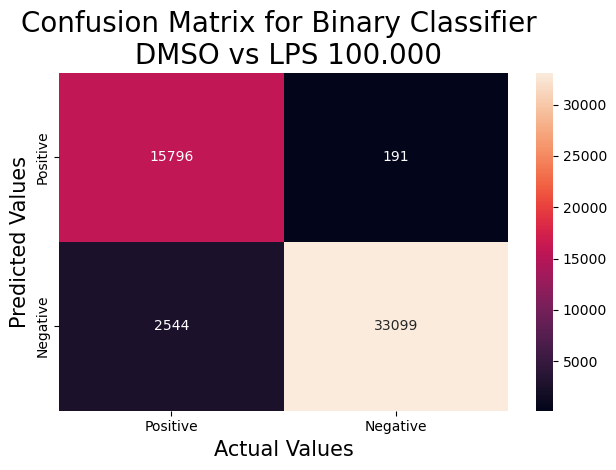

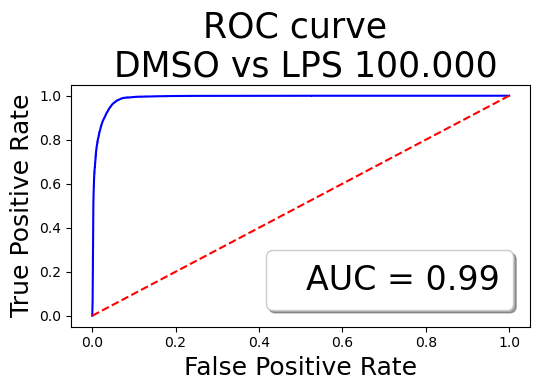

DMSO_0.100_DMSO_0.025 Thapsigargin_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.72      0.93      0.81     35643
           1       0.24      0.06      0.10     13766

    accuracy                           0.69     49409
   macro avg       0.48      0.49      0.45     49409
weighted avg       0.59      0.69      0.61     49409



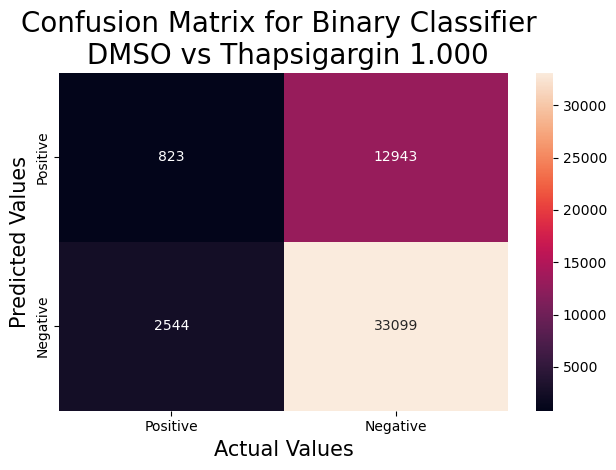

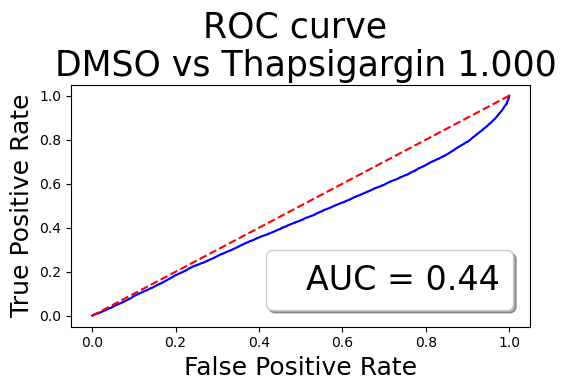

DMSO_0.100_DMSO_0.025 Thapsigargin_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.72      0.93      0.81     35643
           1       0.11      0.02      0.04     13212

    accuracy                           0.68     48855
   macro avg       0.41      0.48      0.42     48855
weighted avg       0.55      0.68      0.60     48855



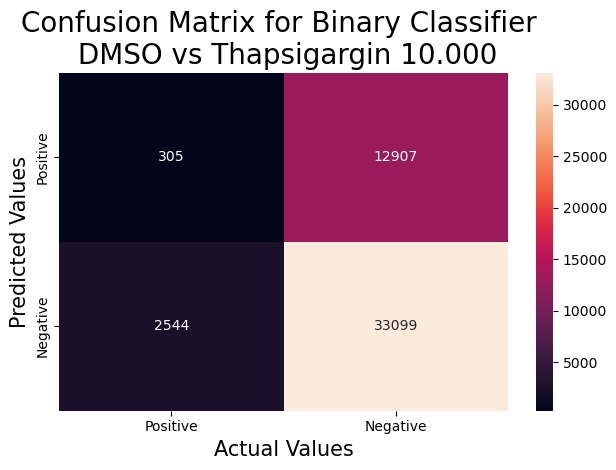

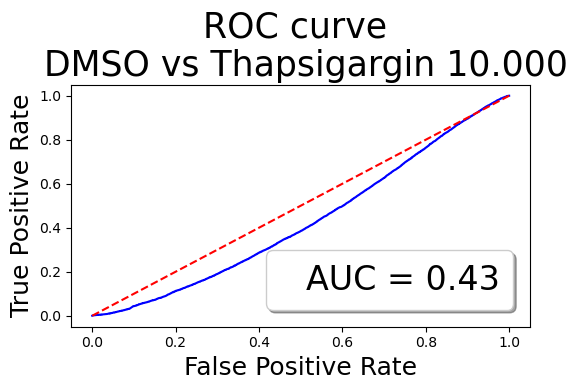

DMSO_0.100_DMSO_0.025 LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.68      0.93      0.79     35643
           1       0.45      0.12      0.19     17510

    accuracy                           0.66     53153
   macro avg       0.56      0.52      0.49     53153
weighted avg       0.60      0.66      0.59     53153



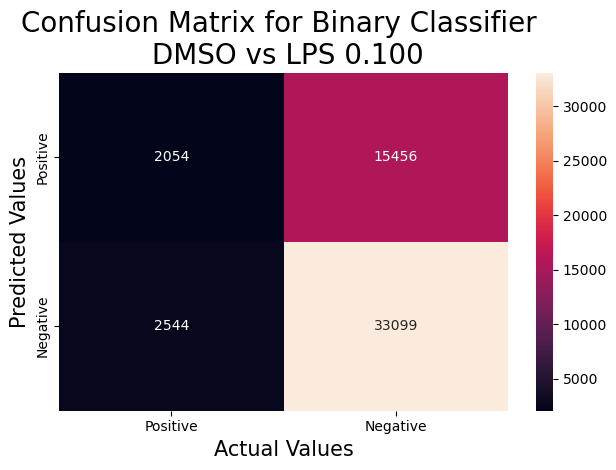

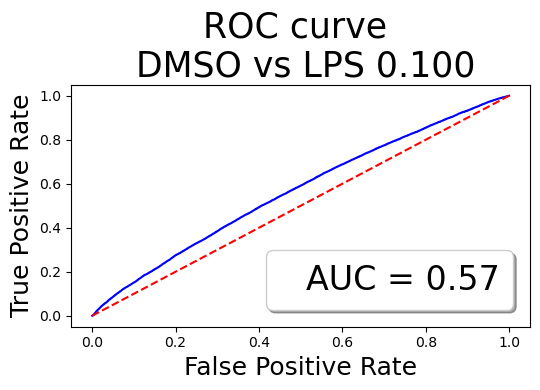

DMSO_0.100_DMSO_0.025 LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.68      0.93      0.79     35643
           1       0.28      0.06      0.10     16458

    accuracy                           0.65     52101
   macro avg       0.48      0.49      0.44     52101
weighted avg       0.56      0.65      0.57     52101



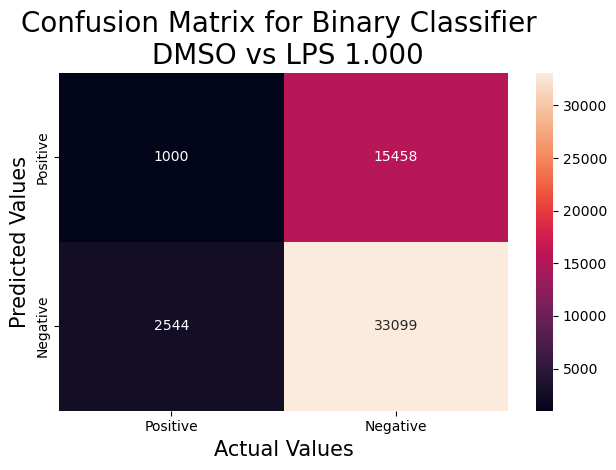

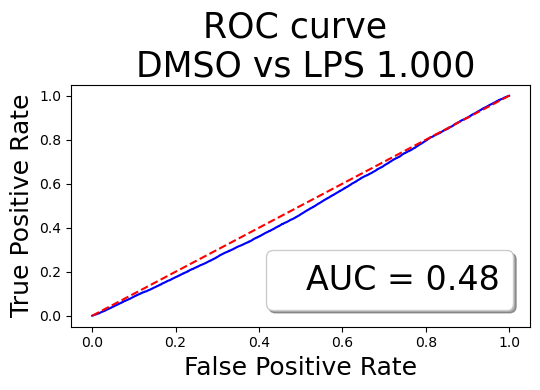

DMSO_0.100_DMSO_0.025 LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.67      0.93      0.78     35643
           1       0.19      0.04      0.06     16810

    accuracy                           0.64     52453
   macro avg       0.43      0.48      0.42     52453
weighted avg       0.52      0.64      0.55     52453



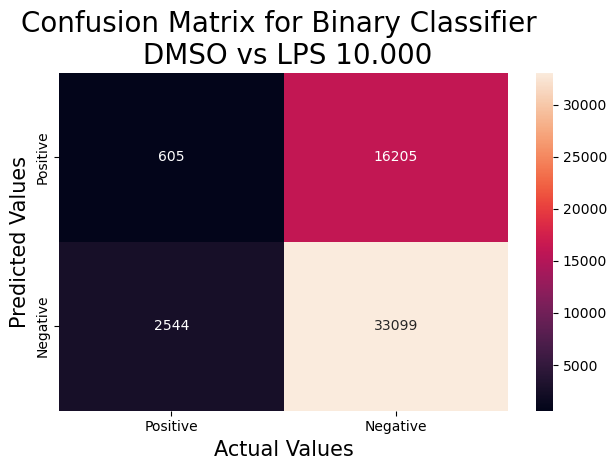

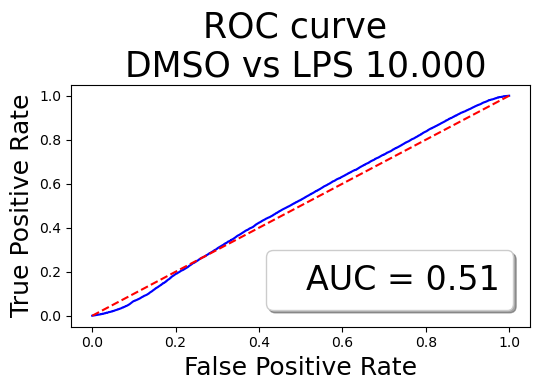

DMSO_0.100_DMSO_0.025 LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     35643
           1       0.86      0.99      0.92     15987

    accuracy                           0.95     51630
   macro avg       0.93      0.96      0.94     51630
weighted avg       0.95      0.95      0.95     51630



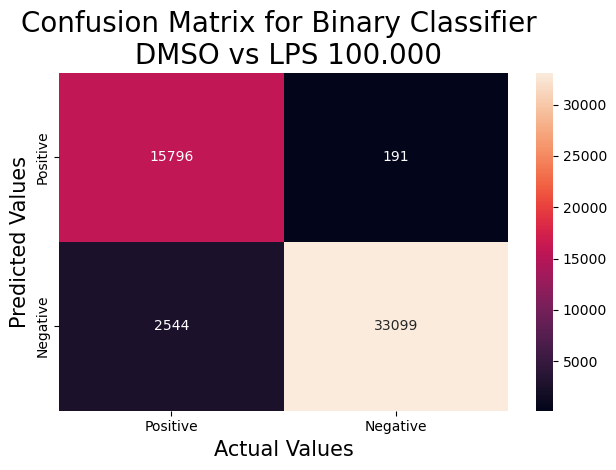

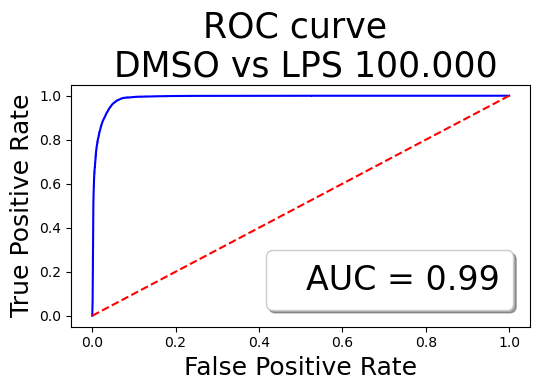

In [7]:
for i, j in paired_treatment_list:
    test_df = df.query(
        f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{j}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}'"
    )
    output_name = (" ").join(
        test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

    print(output_name)

    title = f'{output_name.split(" ")[0].split("_")[0]} vs {(" ").join(output_name.split(" ")[1].split("_")[:2])}'
    test_loop(test_df, output_name, title)